In [1]:
import json
import os.path as osp
import sys

import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm_notebook as tqdm

sys.path.insert(0, '../src/')


In [2]:
base_dir = osp.join('..', 'output', 'pnml_min_norm_20200305_212447')


In [3]:
with open(osp.join(base_dir, 'params.json')) as file:
    params = json.load(file)
x_train, y_train = params['x_train'], params['y_train']
poly_deg_list = params['poly_degree_list']

# Load
res_dict = {}
for poly_deg in poly_deg_list:
    file_name = osp.join(base_dir, f'res_poly_deg_{poly_deg}_lamb_0.0.npy')
    if not osp.exists(file_name):
        continue
    loaded_list = np.load(file_name, allow_pickle=True)
    loaded_list = sorted(loaded_list, key=lambda k: k['x_test'])

    x_test = [res['x_test'] for res in loaded_list]
    regret = [res['regret'] for res in loaded_list]
    y_hat_erm = [res['y_hat_erm'] for res in loaded_list]

    res_dict[poly_deg] = {'x_test': x_test,
                          'regret': regret,
                          'y_hat_erm': y_hat_erm,
                          'x_train': x_train,
                          'y_train': y_train}
print(res_dict.keys())


dict_keys([4, 50, 150])


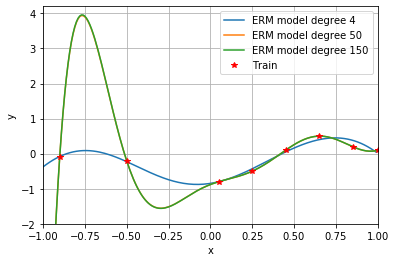

In [10]:
for poly_deg, res in res_dict.items():
    plt.plot(res['x_test'], res['y_hat_erm'],
             label=f'ERM model degree {poly_deg}')
plt.plot(x_train, y_train, 'r*', label='Train')
plt.grid()
plt.ylabel('y')
plt.xlabel('x')
plt.ylim(-2, 4.2)
plt.xlim(-1, 1)
plt.legend()
plt.show()


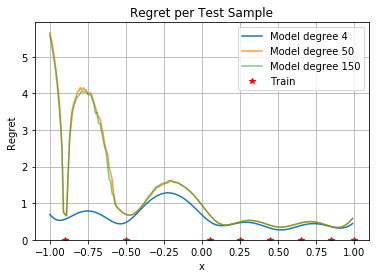

In [9]:
alpha = 1.0
for poly_deg, res in res_dict.items():
    plt.plot(res['x_test'], res['regret'],
             label=f'Model degree {poly_deg}', alpha=alpha)
    alpha -= 0.2
plt.plot(x_train, [0] * len(x_train), 'r*', label='Train')
plt.grid()
plt.ylabel('Regret')
plt.xlabel('x')
plt.title('Regret per Test Sample')
plt.ylim(bottom=0.0)
# plt.xlim(left=0.75)
plt.legend()
plt.show()


# Train vs Test loss

In [6]:
from data_utils import DataCosine
from pnml_min_norm_utils import PnmlMinNorm

# User params
x_test_list = [-0.75, -0.25, 0.5]
poly_degree = 50
x_test = x_test_list[-1]
lamb = 0


In [7]:
loss_res_dict = {}
for x_test in x_test_list:
    # Data Init
    data_h = DataCosine(params['x_train'], params['y_train'])
    phi_train = data_h.create_train(poly_degree)
    phi_test = data_h.convert_point_to_features(x_test, poly_degree)

    y_train = data_h.y
    theta_erm = data_h.fit_least_squares_estimator(phi_train, y_train, lamb)
    y_hat_erm = phi_test.T.dot(theta_erm)
    max_norm = np.sum(theta_erm ** 2)

    # pNML Init
    pnml_h = PnmlMinNorm()
    pnml_h.set_erm_predictor(theta_erm)
    pnml_h.set_y_interval(params['y_min'], params['y_max'], params['dy'])
    pnml_h.min_sigma_square = params['min_sigma_square']
    phi = pnml_h.add_test_to_train(phi_train, phi_test)

    # Iterate on y test
    train_loss_list = []
    test_loss_list = []

    y_test_list = y_hat_erm + np.linspace(-10, 10, 1000)
    for y_test in tqdm(y_test_list):
        y = np.append(y_train, y_test)
        theta = pnml_h.calc_constraint_theta(phi, y, max_norm)
        y_hat = phi_test.T.dot(theta)

        train_loss = np.mean((y_train - theta.T.dot(phi_train)**2))
        test_loss = np.mean((y_test - theta.T.dot(phi_test))**2)

        train_loss_list.append(train_loss)
        test_loss_list.append(test_loss)

    loss_res_dict[x_test] = {'train_loss': train_loss_list,
                             'test_loss': test_loss_list,
                             'y_test_list': y_test_list,
                             'y_hat_erm': y_hat_erm}


2020-03-06 15:10:34.316 | INFO     | data_utils:create_train:32 - Create train: num of features 50


/Users/kobibi/anaconda3/envs/pt36/lib/python3.6/site-packages/scipy/optimize/_constraints.py:331: OptimizeWarning: Constraint options `finite_diff_jac_sparsity`, `finite_diff_rel_step`, `keep_feasible`, and `hess`are ignored by this method.
  "are ignored by this method.", OptimizeWarning)
2020-03-06 15:11:16.352 | INFO     | data_utils:create_train:32 - Create train: num of features 50


2020-03-06 15:11:49.282 | INFO     | data_utils:create_train:32 - Create train: num of features 50


<Figure size 432x288 with 0 Axes>

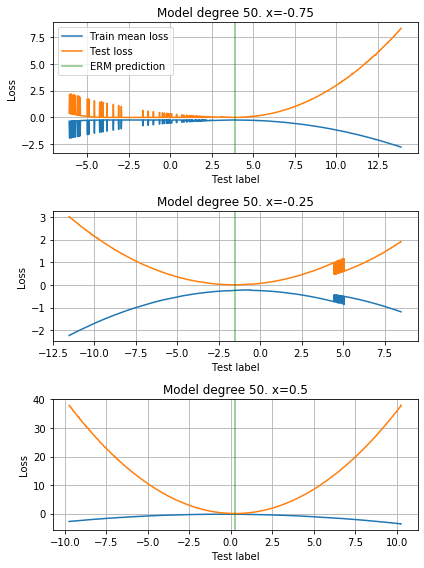

In [8]:
w, h = plt.figure().get_size_inches()
fig, axs = plt.subplots(len(loss_res_dict), 1, figsize=(w, 2*h))
for ax, (x_test, loss_dict) in zip(axs, loss_res_dict.items()):
    ax.plot(loss_dict['y_test_list'], loss_dict['train_loss'],
            label='Train mean loss')
    ax.plot(loss_dict['y_test_list'], loss_dict['test_loss'],
            label='Test loss')
    ax.set_xlabel('Test label')
    ax.set_ylabel('Loss')
    ax.set_title('Model degree {}. x={}'.format(poly_degree, x_test))
    ax.axvline(loss_dict['y_hat_erm'],
               label='ERM prediction', color='g', alpha=0.5)
    ax.grid()
axs[0].legend()

plt.tight_layout()
plt.show()
